In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [1]:
# https://zestedesavoir.com/tutoriels/1760/un-peu-de-machine-learning-avec-les-svm/
# https://ichi.pro/fr/guide-du-debutant-sur-la-classification-de-texte-avec-scikit-learn-109003449397050
# https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [3]:
Corpus = pd.read_csv("Données Wikipédia/Jeu de données final/donnees_wiki_total.csv")


#Corpus = pd.read_csv("test.csv") A mettre comme ça parce que moi j'avais un bugg (et ca separe les mots de cotent par des ,)
Corpus

,content,V1,pages_links,pages_names,subcategory,suicide
0,Warren�s parents were Eliza Ann Brown (1824-1...,52,https://en.wikipedia.org//wiki/Harry_Marsh_Warren,Harry_Marsh_Warren,suicide,True
1,"After her ALS diagnosis , Rodriquez reque...",103,https://en.wikipedia.org//wiki/Sue_Rodriguez,Sue_Rodriguez,Assisted_suicide,True
2,Ames was born Mercedes Grabowski in Antigonis...,116,https://en.wikipedia.org//wiki/August_Ames,August_Ames,Bullying_and_suicide,True
3,"Chen was born and raised in Chinatown , Manh...",119,https://en.wikipedia.org//wiki/Suicide_of_Dann...,Suicide_of_Danny_Chen,Bullying_and_suicide,True
4,"Halligan was born on December 18 , 1989 , He...",125,https://en.wikipedia.org//wiki/Suicide_of_Ryan...,Suicide_of_Ryan_Halligan,Bullying_and_suicide,True
...,...,...,...,...,...,...
2969,"Steele was born in Dallas , Texas , the dau...",7838,https://en.wikipedia.org//wiki/Sydnee_Steele,Sydnee_Steele,Pornographic_film_actors_from_Texas,False
2970,Texas's first scene was with Jack Venice in...,7840,https://en.wikipedia.org//wiki/Alexis_Texas,Alexis_Texas,Pornographic_film_actors_from_Texas,False
2971,Dorothiea Hundley was born and raised in Radf...,7845,https://en.wikipedia.org//wiki/Seka_(actress),Seka_(actress),Pornographic_film_actors_from_Virginia,False
2972,"Newton was born in Eau Claire , Wisconsin . ...",7855,https://en.wikipedia.org//wiki/William_Arnold_...,William_Arnold_Newton,Pornographic_film_actors_from_Wisconsin,False


In [4]:
Corpus.shape

(2974, 6)

# Visualisation et Traitement

In [5]:
##On commence le nettoyage des données en cherchant s'il y a des lignes dupliqués. 
Corpus = Corpus.drop_duplicates()

In [7]:
#On verifie qu'il y ai aucune valeur de content nulle
Corpus['content'].isnull().sum()

0

In [ ]:
Corpus=Corpus.dropna()
Corpus['content'].isnull().sum()

In [ ]:
import seaborn as sns
Corpus['suicide'].value_counts()
sns.countplot(x='suicide', data=Corpus, palette= "hls")
plt.title("nombre de textes par catégorie")
plt.show()

In [ ]:
Corpus['suicide'].value_counts()

# Traitement

In [ ]:
df_parfaitX = Corpus.loc[Corpus['suicide']==True,:]
df_parfaitY = Corpus.loc[Corpus['suicide']==False,:]

In [ ]:
df_parfaitY = df_parfaitY.sample(n=1228)
Corpus = pd.concat([df_parfaitX,df_parfaitY])
Corpus = Corpus.reset_index(drop =True)

In [ ]:
Corpus

In [ ]:
import seaborn as sns
Corpus['suicide'].value_counts()
sns.countplot(x='suicide', data=Corpus, palette= "hls")
plt.title("nombre de textes par catégorie")
plt.show()

In [ ]:
Corpus['suicide'].value_counts()

# Traitement de la données texte pour le model

In [10]:
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['content'] = [entry.lower() for entry in Corpus['content']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['tokenize']= [word_tokenize(entry) for entry in Corpus['content']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['tokenize']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

In [11]:
Corpus

,content,V1,pages_links,pages_names,subcategory,suicide,tokenize,text_final
0,warren�s parents were eliza ann brown (1824-1...,52,https://en.wikipedia.org//wiki/Harry_Marsh_Warren,Harry_Marsh_Warren,suicide,True,"[warren�s, parents, were, eliza, ann, brown, (...","['parent', 'eliza', 'ann', 'brown', 'william',..."
1,"after her als diagnosis , rodriquez reque...",103,https://en.wikipedia.org//wiki/Sue_Rodriguez,Sue_Rodriguez,Assisted_suicide,True,"[after, her, als, diagnosis, ,, rodriquez, req...","['al', 'diagnosis', 'rodriquez', 'request', 'h..."
2,ames was born mercedes grabowski in antigonis...,116,https://en.wikipedia.org//wiki/August_Ames,August_Ames,Bullying_and_suicide,True,"[ames, was, born, mercedes, grabowski, in, ant...","['ames', 'bear', 'mercedes', 'grabowski', 'ant..."
3,"chen was born and raised in chinatown , manh...",119,https://en.wikipedia.org//wiki/Suicide_of_Dann...,Suicide_of_Danny_Chen,Bullying_and_suicide,True,"[chen, was, born, and, raised, in, chinatown, ...","['chen', 'bear', 'raise', 'chinatown', 'manhat..."
4,"halligan was born on december 18 , 1989 , he...",125,https://en.wikipedia.org//wiki/Suicide_of_Ryan...,Suicide_of_Ryan_Halligan,Bullying_and_suicide,True,"[halligan, was, born, on, december, 18, ,, 198...","['halligan', 'bear', 'december', 'describe', '..."
...,...,...,...,...,...,...,...,...
2969,"steele was born in dallas , texas , the dau...",7838,https://en.wikipedia.org//wiki/Sydnee_Steele,Sydnee_Steele,Pornographic_film_actors_from_Texas,False,"[steele, was, born, in, dallas, ,, texas, ,, t...","['steele', 'bear', 'dallas', 'texas', 'daughte..."
2970,texas's first scene was with jack venice in...,7840,https://en.wikipedia.org//wiki/Alexis_Texas,Alexis_Texas,Pornographic_film_actors_from_Texas,False,"[texas, 's, first, scene, was, with, jack, ven...","['texas', 'first', 'scene', 'jack', 'venice', ..."
2971,dorothiea hundley was born and raised in radf...,7845,https://en.wikipedia.org//wiki/Seka_(actress),Seka_(actress),Pornographic_film_actors_from_Virginia,False,"[dorothiea, hundley, was, born, and, raised, i...","['dorothiea', 'hundley', 'bear', 'raise', 'rad..."
2972,"newton was born in eau claire , wisconsin . ...",7855,https://en.wikipedia.org//wiki/William_Arnold_...,William_Arnold_Newton,Pornographic_film_actors_from_Wisconsin,False,"[newton, was, born, in, eau, claire, ,, wiscon...","['newton', 'bear', 'eau', 'claire', 'wisconsin..."


In [13]:
y=Corpus['suicide']
X=Corpus['content']

In [14]:
#These will now contain for each row a list of unique integer number and its associated importance 
#as calculated by TF-IDF.
vector = TfidfVectorizer(max_features=5000) #Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000.
X=vector.fit_transform(X)

In [15]:
#Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['suicide'],test_size=0.3)

In [16]:
#transforme les string en numérique pour que le model puisse prendre les données 
#Encoder = LabelEncoder()
#Train_Y = Encoder.fit_transform(Train_Y)
#Test_Y = Encoder.fit_transform(Test_Y)

In [17]:
#These will now contain for each row a list of unique integer number and its associated importance 
#as calculated by TF-IDF.
#Tfidf_vect = TfidfVectorizer(max_features=5000) #Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000.

#Tfidf_vect.fit(Corpus['text_final'])
#Train_X_Tfidf = Tfidf_vect.transform(Train_X)
#Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [18]:
#data vectorisé
#1: Row number of ‘Train_X_Tfidf’, 
#2: Unique Integer number of each word in the first row, 
#3: Score calculated by TF-IDF Vectorizer
print(X)

  (0, 2978)	0.0666163476639883
  (0, 1353)	0.03802081411565555
  (0, 92)	0.044060873327097225
  (0, 860)	0.07346586973154817
  (0, 1730)	0.07698700824511566
  (0, 294)	0.07475544946215264
  (0, 2904)	0.03802081411565555
  (0, 23)	0.06850310373122064
  (0, 3368)	0.04756356468273484
  (0, 964)	0.05237974585356278
  (0, 4973)	0.026887119671100478
  (0, 4108)	0.031897630401118114
  (0, 1928)	0.01785085504517666
  (0, 2920)	0.05903950153120458
  (0, 1892)	0.024229653957205943
  (0, 2552)	0.05027635250313998
  (0, 2528)	0.03514173408741915
  (0, 1208)	0.0388967018000315
  (0, 4937)	0.030558944538567594
  (0, 1060)	0.0635403377308931
  (0, 708)	0.07409368359848988
  (0, 4307)	0.05519319091873606
  (0, 1033)	0.26189872926781393
  (0, 610)	0.38493504122557826
  (0, 576)	0.18392633684379026
  :	:
  (2973, 365)	0.09347398987313582
  (2973, 3538)	0.14773929775414268
  (2973, 4299)	0.18955301479500733
  (2973, 4868)	0.07650695590284627
  (2973, 461)	0.07409593814710143
  (2973, 323)	0.0850534934471

In [19]:
#The below syntax to see the vocabulary that it has learned from the corpus

print(vector.vocabulary_)


{'warren': 4824, 'parents': 3366, 'were': 4862, 'ann': 434, 'brown': 830, '1891': 21, 'and': 414, 'william': 4895, 'who': 4877, 'made': 2850, 'with': 4914, 'his': 2271, 'brother': 827, 'in': 2388, 'hudson': 2332, 'new': 3173, 'hampshire': 2166, 'was': 4827, 'the': 4525, 'youngest': 4983, 'of': 3252, 'their': 4531, 'five': 1895, 'children': 1017, 'born': 767, 'on': 3277, '19': 31, 'april': 472, 'three': 4564, 'weeks': 4850, 'after': 316, 'father': 1822, 'died': 1452, 'leaving': 2697, 'mother': 3086, 'to': 4588, 'raise': 3719, 'family': 1805, 'she': 4125, 'lived': 2769, 'almost': 377, 'next': 3180, 'door': 1513, 'her': 2243, 'law': 2677, 'he': 2212, 'may': 2938, 'have': 2198, 'provided': 3665, 'some': 4227, 'support': 4421, 'however': 2331, 'remarried': 3821, 'local': 2778, '75': 213, 'year': 4972, 'old': 3268, 'farmer': 1813, 'called': 874, 'philip': 3447, 'hart': 2189, 'within': 4915, 'months': 3069, 'by': 862, 'about': 236, 'living': 2772, 'where': 4869, 'attended': 544, 'hill': 2265,

# SVM 

In [20]:
# Classifier - Algorithm - SVM
#Instancier un SVM linéaire sur les données
#SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM.fit(Test_X_Tfidf,Train_Y)
# predict the labels on validation dataset
#predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
#print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))


In [21]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
model=svm.SVC(kernel='linear',gamma='auto')
model.fit(X,y)
y_pred = cross_val_predict(model, X, y, cv=5)
cm = confusion_matrix(y, y_pred)
print("Binary classification-----")
recall = np.diag(cm) / np.sum(cm, axis=1)
precision = np.diag(cm) / np.sum(cm, axis=0)

        
print(classification_report(y, y_pred))

Binary classification-----
              precision    recall  f1-score   support

       False       0.90      0.90      0.90      2105
        True       0.75      0.76      0.76       869

    accuracy                           0.86      2974
   macro avg       0.83      0.83      0.83      2974
weighted avg       0.86      0.86      0.86      2974



In [22]:
accuracy_score(y,y_pred)

0.8564223268325487

# Matrice de confusion

In [23]:
#pip install mlxtend


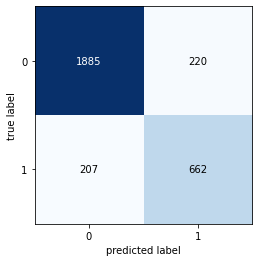

In [24]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Random-Forest

In [25]:

from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=500)
model.fit(X,y)
y_pred = cross_val_predict(model, X, y, cv=5)
print("Binary classification-----")
cm = confusion_matrix(y, y_pred)
recall = np.diag(cm) / np.sum(cm, axis=1)
precision = np.diag(cm) / np.sum(cm, axis=0)

        
print(classification_report(y, y_pred))


Binary classification-----
              precision    recall  f1-score   support

       False       0.88      0.94      0.91      2105
        True       0.83      0.68      0.75       869

    accuracy                           0.87      2974
   macro avg       0.85      0.81      0.83      2974
weighted avg       0.86      0.87      0.86      2974



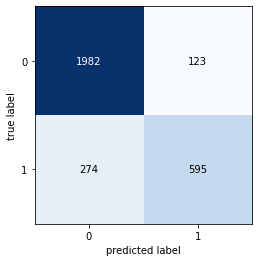

In [26]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()